## Author: Chia-Yun (Sandy) Chiang

# Introduction

In this project, I used hypothesis testing to test whether marketing campaign will influence average of distance driven in both SFO and LAX and compared the results in both area.

### Setup

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import f_oneway
from scipy.stats import bartlett
from scipy.stats import levene
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Set style
plt.style.use('seaborn-white')
plt.style.use('seaborn-pastel')
plt.rcParams["figure.figsize"] = (24,8)

In [3]:
# Data source
lax_path = "https://docs.google.com/spreadsheets/d/e/2PACX-1vR8hOyZL6ne16YDANKKSQfv0PHitM-2zR36m8wWGib5i-s9r0Eav0vTPkXRpySBMc42QkLw1POcy0m3/pub?gid=133017553&single=true&output=csv"
sfo_path = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRJent9hoysHMpVZxOldoZm65ufLAYHc1KgmkAaJBlXvzWJxa918D5Km2UfTDZuOB9h0d1OO-RK0PDf/pub?gid=1761029431&single=true&output=csv"

In [4]:
# Read data
lax = pd.read_csv(lax_path)
sfo = pd.read_csv(sfo_path)

## SFO hypothesis testing


- H0: The average daily miles driven per hour when launching the marketing campaign is the same as the average daily miles driven per hour when we do not launch the marketing campaign in SFO.     
- H1: The average daily miles driven per hour when marketing campaign are launched are greater than the average daily miles driven per hour when marketing campaign not launched in SFO.

In [68]:
sfo.head(3)

,Date,SFO - Avg. Daily Miles Driven Per Hour,Marketing_Campaign
0,09/14/2019,76.367627,0
1,09/15/2019,100.767635,0
2,09/16/2019,95.046741,0


In [69]:
sfo.shape

(103, 3)

In [70]:
sfo.isnull().sum()

Date                                      0
SFO - Avg. Daily Miles Driven Per Hour    0
Marketing_Campaign                        0
dtype: int64

In [71]:
sfo.describe()

,SFO - Avg. Daily Miles Driven Per Hour,Marketing_Campaign
count,103.000000,103.000000
mean,57.955457,0.281553
std,31.412760,0.451956
min,3.208774,0.000000
25%,37.690567,0.000000
50%,63.369437,0.000000
75%,78.685861,1.000000
max,125.087980,1.000000


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


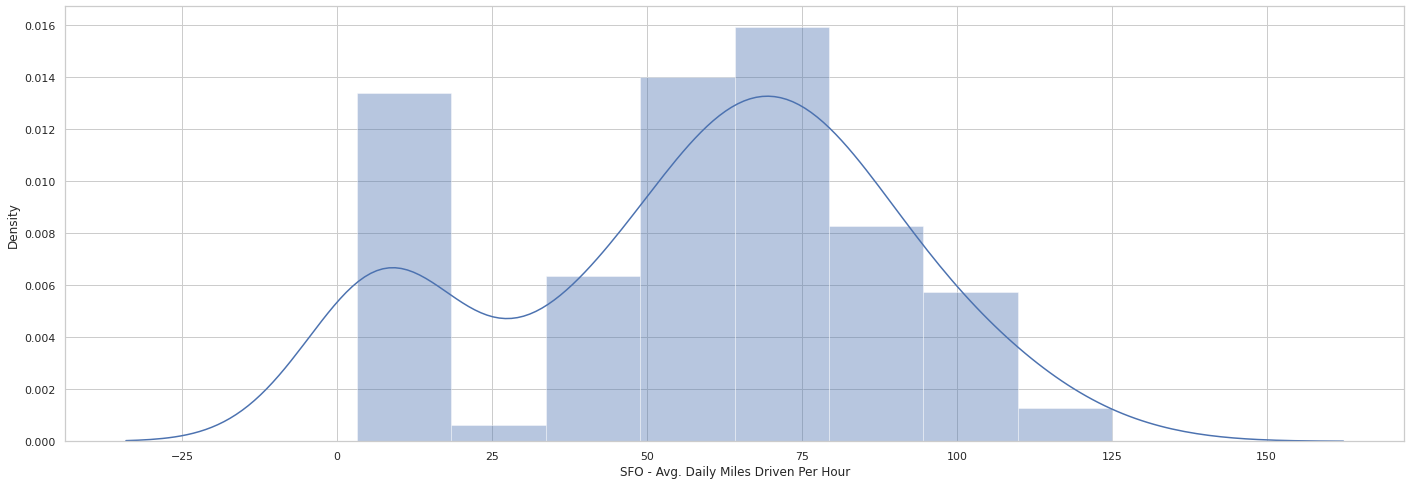

In [72]:
sns.set(style='whitegrid')
ax = sns.distplot(sfo['SFO - Avg. Daily Miles Driven Per Hour'], bins = 8)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


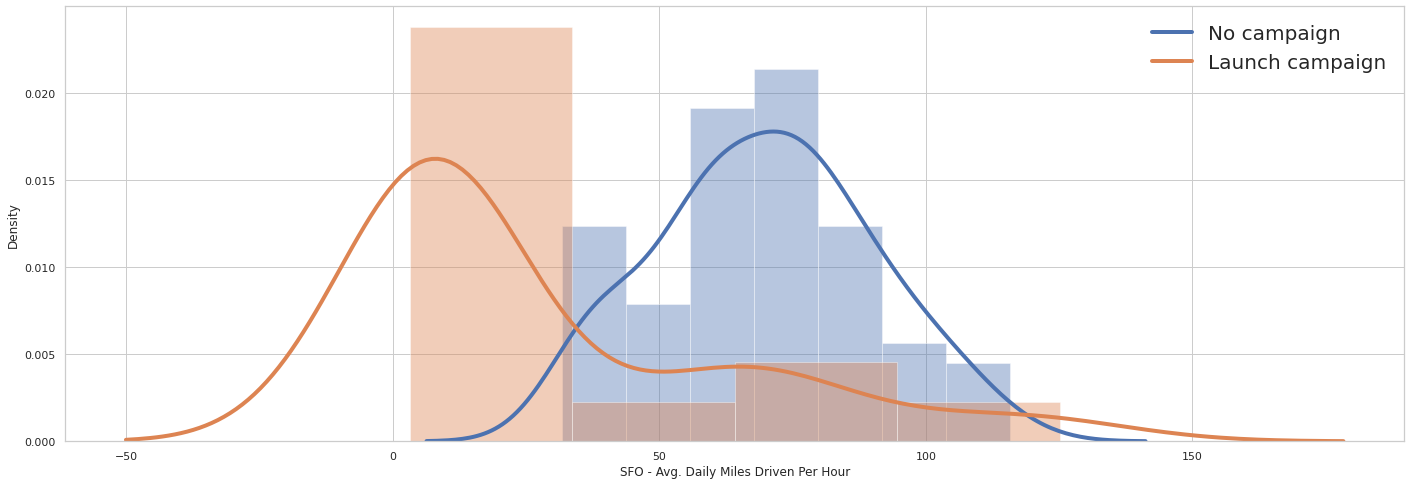

In [73]:
sfo_data0 = sfo["SFO - Avg. Daily Miles Driven Per Hour"].loc[sfo["Marketing_Campaign"] == 0]
sfo_data1 = sfo["SFO - Avg. Daily Miles Driven Per Hour"].loc[sfo["Marketing_Campaign"] == 1]

sns.set_style('whitegrid')
ax = sns.distplot(sfo_data0, hist=True, kde_kws=dict(linewidth=4))
ax = sns.distplot(sfo_data1, hist=True, kde_kws=dict(linewidth=4))
plt.legend(['No campaign','Launch campaign'],fontsize=20)

In [74]:
# ANOVA
alpha = 0.05
sfo_stat, sfo_p = f_oneway(sfo_data0, sfo_data1)
print("SFO statistics is %.3f, p value is %.3f" % (sfo_stat, sfo_p))
if sfo_p <= alpha:
  print("Reject H0. Different distribution (alpha = 0.05) ")
else:
  print("Fail to reject H0. Same distribution (alpha = 0.05)")

SFO statistics is 59.938, p value is 0.000
Reject H0. Different distribution (alpha = 0.05) 


In [75]:
# double check sfo p-value
sfo_p

7.732992251109562e-12

## Test for homoscedasticity (population variance are equal)

In [76]:
stat, p_sfo_b = bartlett(sfo_data0, sfo_data1)
print(p_sfo_b)
if p_sfo_b <= alpha:
  print("Not meet the homoscedasticity assumption.")
else:
  print("Meet the homoscedasticity assumption.")

0.00020286803638112704
Not meet the homoscedasticity assumption.


- Since our SFO data does not meet the homoscedasticity assumption, let's try non-parametric testing using Mann-Whitney rank test 

## Mann-Whitney rank test for SFO dataset

In [77]:
stats.mannwhitneyu(sfo_data0, sfo_data1)

MannwhitneyuResult(statistic=343.0, pvalue=4.418529922582482e-08)

- Using Mann-Whitney rank test for sfo dataset, we get a very small p-value, which indicates that our samples comes from different populations.

    
      
**Reference**
- [scipy.stats.f_oneway](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html)
- [scipy.stats.bartlett](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html)
- [Mann–Whitney U test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test)



## LAX hypothesis testing


- H0: The average daily miles driven per hour when launching the marketing campaign is the same as the average daily miles driven per hour when we do not launch the marketing campaign in LAX.     
- H1: The average daily miles driven per hour when marketing campaign are launched are greater than the average daily miles driven per hour when marketing campaign not launched in LAX.

In [78]:
lax.head(3)

,Date,LAX - Avg. Daily Miles Driven Per Hour,Marketing_Campaign
0,09/14/2019,50.908508,0
1,09/15/2019,34.078377,0
2,09/16/2019,120.554627,0


In [79]:
lax.shape

(103, 3)

In [80]:
lax.isnull().sum()

Date                                      0
LAX - Avg. Daily Miles Driven Per Hour    0
Marketing_Campaign                        0
dtype: int64

In [81]:
lax.describe()

,LAX - Avg. Daily Miles Driven Per Hour,Marketing_Campaign
count,103.000000,103.000000
mean,119.006600,0.291262
std,72.056692,0.456566
min,-103.447844,0.000000
25%,69.590644,0.000000
50%,107.187604,0.000000
75%,161.570768,1.000000
max,303.557044,1.000000


- min value is less than 0 --> not reasonable

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


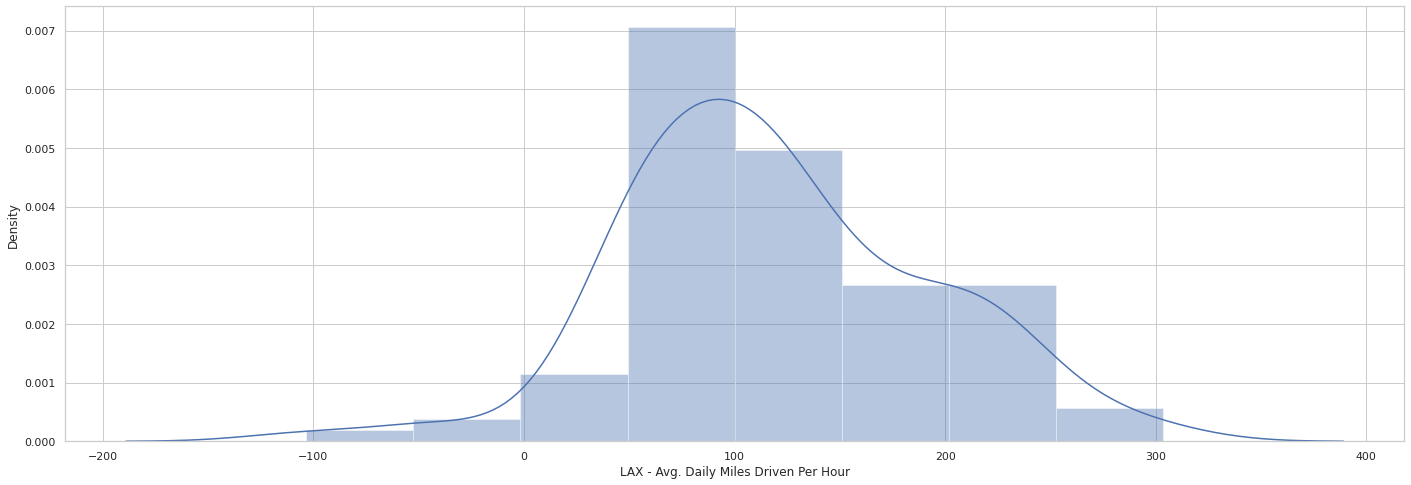

In [82]:
sns.set(style='whitegrid')
ax = sns.distplot(lax['LAX - Avg. Daily Miles Driven Per Hour'], bins = 8)

In [83]:
# remove negative and 0 value
lax.drop(lax[lax["LAX - Avg. Daily Miles Driven Per Hour"]<= 0].index, inplace=True)

In [84]:
lax.shape

(100, 3)

In [85]:
lax.describe()

,LAX - Avg. Daily Miles Driven Per Hour,Marketing_Campaign
count,100.000000,100.000000
mean,124.513652,0.300000
std,65.378349,0.460566
min,11.743018,0.000000
25%,73.154924,0.000000
50%,109.324168,0.000000
75%,164.029623,1.000000
max,303.557044,1.000000


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


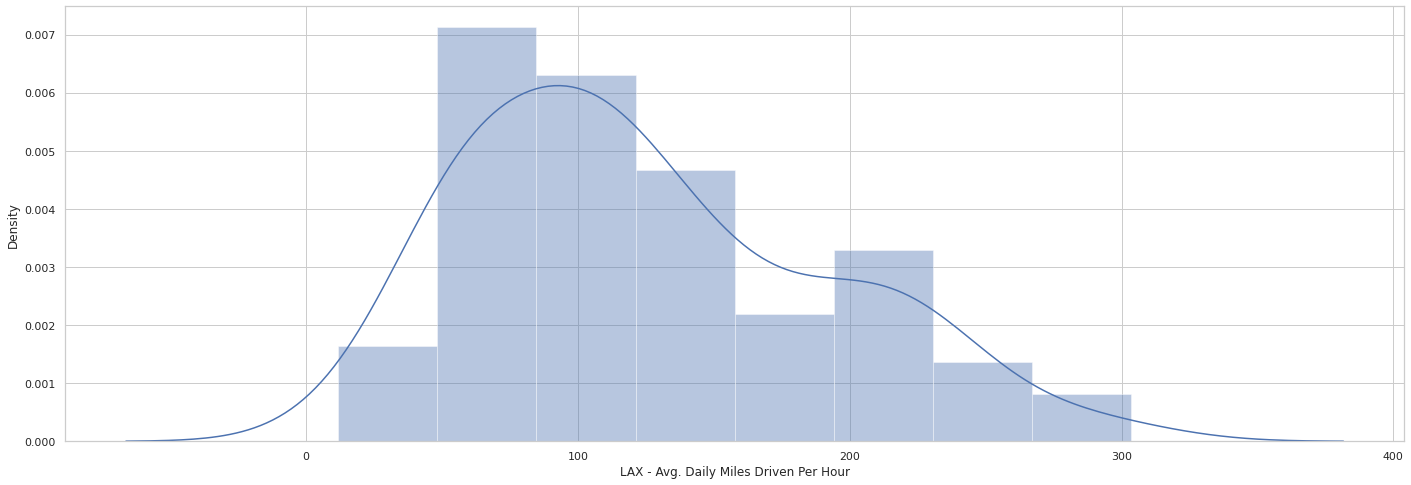

In [86]:
sns.set(style='whitegrid')
ax = sns.distplot(lax['LAX - Avg. Daily Miles Driven Per Hour'], bins = 8)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


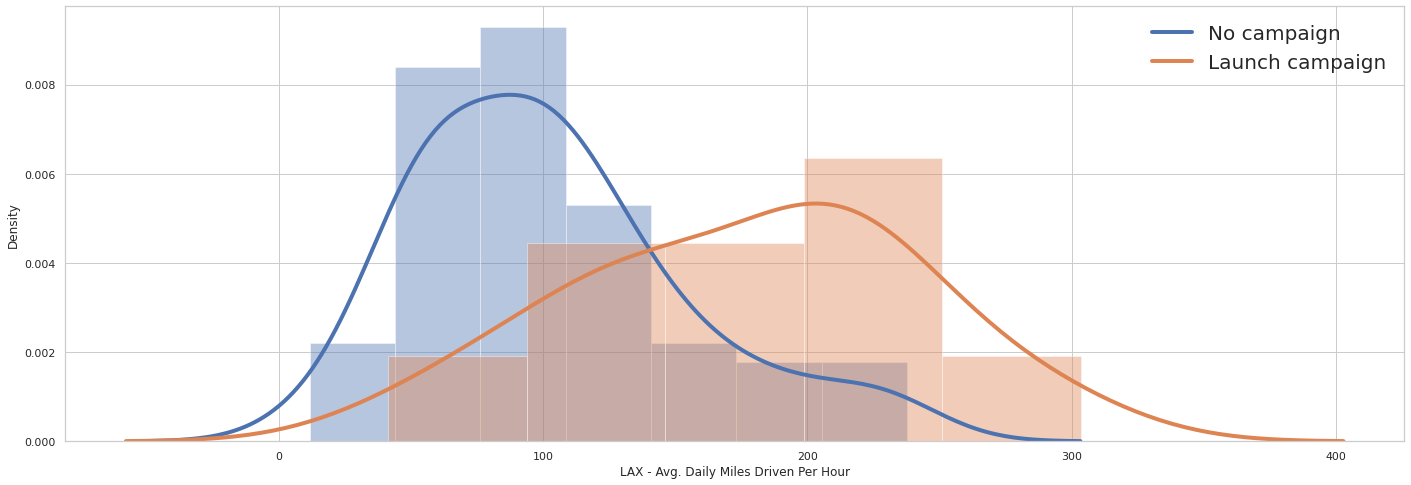

In [87]:
lax_data0 = lax["LAX - Avg. Daily Miles Driven Per Hour"].loc[lax["Marketing_Campaign"] == 0]
lax_data1 = lax["LAX - Avg. Daily Miles Driven Per Hour"].loc[lax["Marketing_Campaign"] == 1]

sns.set_style('whitegrid')
ax = sns.distplot(lax_data0, hist=True, kde_kws=dict(linewidth=4))
ax = sns.distplot(lax_data1, hist=True, kde_kws=dict(linewidth=4))
plt.legend(['No campaign','Launch campaign'],fontsize=20)

In [88]:
# ANOVA
alpha = 0.05
lax_stat, lax_p = f_oneway(lax_data0, lax_data1)
print("LAX statistics is %.3f, p value is %.3f" % (lax_stat, lax_p))
if lax_p <= alpha:
  print("Reject H0. Different distribution (alpha = 0.05) ")
else:
  print("Fail to reject H0. Same distribution (alpha = 0.05)")

LAX statistics is 38.328, p value is 0.000
Reject H0. Different distribution (alpha = 0.05) 


In [89]:
# double check lax p-value
lax_p

1.3987390398773993e-08

### Test for homoscedasticity (population variance are equal)

In [90]:
stat, p_lax_b = bartlett(lax_data0, lax_data1)
print(p_lax_b)
alpha = 0.05
if p_lax_b <= alpha:
  print("Not meet the homoscedasticity assumption.")
else:
  print("Meet the homoscedasticity assumption.")

0.10835425684871527
Meet the homoscedasticity assumption.


# Summary of marketing campaign hypothesis testing:

## SFO 
- Assume our data meets all the assumptions of one-way ANOVA testing, we could find that launching campaign or not would influence the average daily miles driven per hour in San Francisco.
- According to the plot, launching campaign in San Francisco does not increase the average of distance driven, to our surprise, it decreases the average of distance driven instead.


## LAX 
- Assume our data meets all the assumptions of one-way ANOVA testing, we could find that launching campaign or not would influence the average daily miles driven per hour in Los Angeles.
- According to the plot, launching campaign in Los Angeles increases the average of distance driven.

## Comparison between SFO and LAX
- Launching campaign in SFO & LAX have different results. In SFO, launching campaign decrease the distance driven; while In LAX, launching campaign increase the distance driven.
- This phenomenon might indicate that people in LAX have high likelihood to take more Uber driven by marketing campaign; while people in SFO might be discouraged by marketing campaign. 
- We are not sure if above statement is true or not since we do not have other kinds of information in our dataset. For example, if these two datasets are sampled in different year or different seansons, say SFO dataset is sampled in winter and LAX dataset is sampled in summer, then maybe the season is the key factor that influences the distance driven.


## Something might affect the validity

There are some **assumptions while implementing the ANOVA**:
- The population distribution is normally distributed
- The samples are independent with each other
- The population variances are equal
- The sample data is randomly sampled


If any of the assumptions failed, our results might not be reliable.

However if we failed to meet some of the ANOVA assumptions (like our SFO dataset), we still could try other methods (**non-parametric testing**), such as Kruskal-Wallis H-test for three or more samples, or Mann-Whitney rank test for two samples.

In our case, we use Mann-Whitney rank test for SFO dataset, then the data should meet the **assumptions of Mann-Whitney rank test**:
- The samples are independent with each other
- The dependent variable are ordinal or continuous variable
- The independent variable are independent categorical groups
- The samples are followed the same shape

If we failed to meet the assumptions, the results might not be reliable.
 
    
**Reference**
- [Mann Whitney U Test](https://www.statisticshowto.com/mann-whitney-u-test/)
